# Object Detection with Cofar-10 Dataset Using ResNet50 Model

In [7]:
#!pip install py7zr

## dependencies

In [8]:
from zipfile import ZipFile
import py7zr
import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf

## dataset

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c cifar-10

 98% 701M/715M [00:10<00:00, 77.1MB/s]
100% 715M/715M [00:11<00:00, 68.1MB/s]


In [11]:
!ls


cifar-10.zip  kaggle.json  sample_data


In [12]:
# unzipping the dataset
dataset = "/content/cifar-10.zip"

with ZipFile(dataset, "r") as zip:
  zip.extractall()
  print("succesfully extracted the dataset")

succesfully extracted the dataset


In [13]:
train_archive = py7zr.SevenZipFile("/content/train.7z", mode="r")
train_archive.extractall()
train_archive.close()

In [14]:
!ls

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


## data exploration and preprocessing

In [15]:
file_names = os.listdir("/content/train")
len(file_names)

50000

In [16]:
print(file_names[:5])
print(file_names[-5:])

['14509.png', '14054.png', '6409.png', '36000.png', '15176.png']
['36376.png', '20845.png', '20655.png', '32450.png', '35233.png']


In [17]:
# labels processing
labels_df = pd.read_csv("/content/trainLabels.csv")
labels_df.shape

(50000, 2)

In [18]:
labels_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [19]:
print(
    labels_df[labels_df["id"] == 29671]
)


          id label
29670  29671  deer


In [20]:
len(labels_df["label"].value_counts())

10

In [21]:
labels_df.tail(10)

,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [22]:
# encoding labels manually
labels_dict = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9,
}

In [23]:
labels_df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [24]:
# mapping
labels = [labels_dict[i] for i in labels_df["label"]]

In [25]:
print(labels_df[:5])
print("-"*50)
print(labels_df[-5:])

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
--------------------------------------------------
          id       label
49995  49996        bird
49996  49997        frog
49997  49998       truck
49998  49999  automobile
49999  50000  automobile


In [26]:
print(labels[:5])
print(labels[-5:])

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


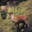

In [27]:
# visualizing sample images
img = cv2.imread("/content/train/29671.png")
cv2_imshow(img)

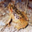

In [28]:
img = cv2.imread("/content/train/7796.png")
cv2_imshow(img)

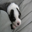

In [29]:
img = cv2.imread("/content/train/45888.png")
cv2_imshow(img)

In [30]:
labels_df[labels_df["id"] == 45888]

,id,label
45887,45888,dog


In [31]:
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [32]:
id_list = list(labels_df["id"])

print(id_list[:5])
print(id_list[-5:])

[1, 2, 3, 4, 5]
[49996, 49997, 49998, 49999, 50000]


In [33]:
# converting images to numpy arrays
train_folder = "/content/train/"
data = []

for id in id_list:
  image = Image.open(train_folder + str(id) + ".png")
  image = np.array(image)
  data.append(image)

In [34]:
type(data[0])

numpy.ndarray

In [35]:
len(data)

50000

In [36]:
data[0].shape

(32, 32, 3)

In [37]:
# converting the image list and label list to np arrays
X, y = np.array(data), np.array(labels)

In [38]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [39]:
print(X.shape)
print(y.shape)

(50000, 32, 32, 3)
(50000,)


In [40]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21
)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [41]:
# normalizing the data (scaling)
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## modelling, training and evaluation

### baseline neural network

In [43]:
# initialization
model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")

])

In [47]:
# compiling the model
model.compile(
    optimizer = 'adam',
    loss = "sparse_categorical_crossentropy",
    metrics = ["acc"]
)

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,322 (770.79 KB)

 Trainable params: 197,322 (770.79 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from sklearn.utils import validation
# training
model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.1,
    epochs = 10
)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.1964 - loss: 2.1167 - val_acc: 0.2982 - val_loss: 1.8717
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3041 - loss: 1.8886 - val_acc: 0.3298 - val_loss: 1.8343
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.3290 - loss: 1.8437 - val_acc: 0.3237 - val_loss: 1.8494
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3397 - loss: 1.8238 - val_acc: 0.3260 - val_loss: 1.8252
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3418 - loss: 1.8188 - val_acc: 0.3380 - val_loss: 1.8166
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.3500 - loss: 1.7982 - val_acc: 0.3415 - val_loss: 1.7940
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.3538 - loss: 1.7941 - val_acc: 0.3478 - val_loss: 1.7752
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3557 - loss: 1.7909 - val_acc: 0.3435 - val_loss: 1.8014
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━

### resnet model

In [56]:
resnet_base = tf.keras.applications.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (256, 256, 3)
)

In [57]:
resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [61]:
model = tf.keras.Sequential([

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.UpSampling2D((2, 2)),

    resnet_base,
    tf.keras.layers.Flatten(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="relu")
])


In [62]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d_9 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)